# Data Preprocessing

In [1]:
#load the training dataset
import pandas as pd
df = pd.read_csv("Disease_train.csv")

In [2]:
[rows, columns] = df.shape
print(f"Columns: {columns}, Rows: {rows}")

Columns: 12, Rows: 4000


# Feature Engineering:

In [3]:
#finding the duplicate rows in the dataset
duplicate_rows = df[df.duplicated()]
#get the index of the duplicates
row_index = duplicate_rows.index.tolist()
#removing the duplicates
df.drop(index=row_index, inplace=True) #to remove the duplicates from the dataset itself
[rows, columns] = df.shape
print(f"Columns: {columns}, Rows: {rows}")

Columns: 12, Rows: 4000


No duplicate rows------------------------

In [4]:
#Handling the missing values
df.isnull().sum()

feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
patient_id    0
diagnosis     0
dtype: int64

No missing data----------------------

## Fliter methods

In [5]:
#variace of each rolumn in df
df.var(axis=0)

feature_1     8.349366e-02
feature_2     8.496879e-02
feature_3     8.201948e-02
feature_4     8.322433e-02
feature_5     8.270496e-02
feature_6     8.404884e-02
feature_7     8.243466e-02
feature_8     8.338032e-02
feature_9     8.224234e-02
feature_10    8.380037e-02
patient_id    2.115087e+06
diagnosis     4.661065e-02
dtype: float64

variance is almost the same

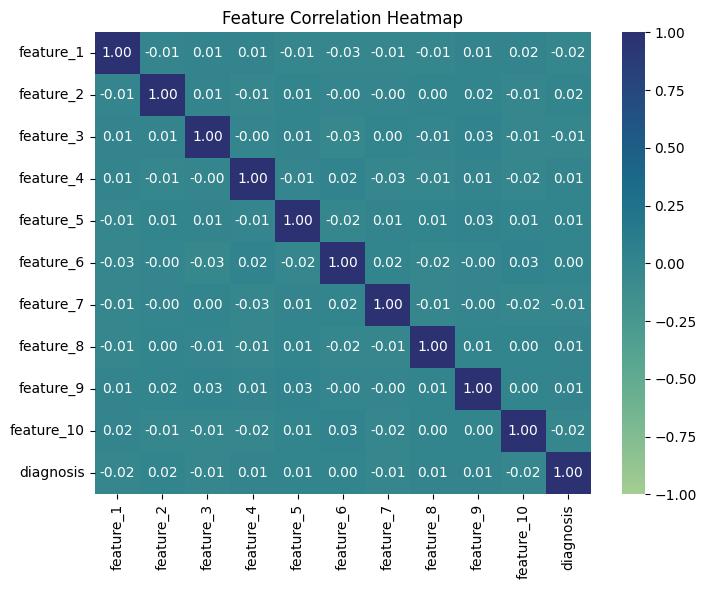

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

features = df.drop(columns='patient_id').columns.tolist()

#Create a heatmap with the correlation between features
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df[features].corr(), annot=True, cmap='crest', fmt=".2f", vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

No extreme correlation, cant use correlation  - filter method

##Wrapper methods

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Split the dataset into training and validation subsets
X = df.drop(columns=['patient_id', 'diagnosis'])
y = df['diagnosis']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Perform Recursive Feature Elimination (RFE) for feature selection
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Transform the training and validation sets
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

print('Selected Features:', selected_features)
print('train test data splitting completed')

Selected Features: Index(['feature_2', 'feature_5', 'feature_6', 'feature_7', 'feature_8'], dtype='object')
train test data splitting completed


# Training and Validation

In [8]:
from sklearn.metrics import accuracy_score
# Train a Random Forest model with default parameters
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rfe, y_train)

# Validate the model
y_pred = rf.predict(X_val_rfe)
accuracy = accuracy_score(y_val, y_pred)

print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.975


# Optimizing Hyperparameters

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters and their values for random search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42, verbose=10)
random_search.fit(X_train_rfe, y_train)

# Get the best model
best_rf = random_search.best_estimator_
print('Best hyperparameters:', random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}


In [10]:
from sklearn.metrics import accuracy_score
# Train a Random Forest model with default parameters
rf = RandomForestClassifier(random_state=42, n_estimators= 100, min_samples_split= 5, min_samples_leaf=4, max_depth = None)
rf.fit(X_train_rfe, y_train)

# Validate the model
y_pred = rf.predict(X_val_rfe)
accuracy = accuracy_score(y_val, y_pred)

print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.9775


# Saving to CSV

In [11]:
# Save the trained model to a file
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load the test data
test_df = pd.read_csv('Disease_test.csv')

# Assuming 'patient_id' is a column in your test data
# Separate the features (excluding 'patient_id')
X_test = test_df.drop(columns=['patient_id'])

# Load the trained model
best_rf = joblib.load('rf_model.pkl')

# Apply RFE transformation on the test data using the trained RFE selector
X_test_rfe = rfe.transform(X_test)

# Predict the target variable using the trained model
y_pred = best_rf.predict(X_test_rfe)

# Add the predictions as a new column to the test DataFrame
test_df['prediction'] = y_pred

# Keep the 'patient_id' and 'diagnosis' columns only
test_df = test_df[['patient_id', 'prediction']]

# Save the DataFrame with predictions to a new CSV file
test_df.to_csv('SE22UCSE076_predictions.csv', index=False)

print('Predictions saved')


Predictions saved
